In [30]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC
import math
import matplotlib.pyplot as plt

# Dataset

We import the dataset from Hastie & Tibshirani book.
This is an artificially generated binary classification problem. Labels are in the set $\{-1,+1\}$.

In [12]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]

# Adaboost implementation

Here we implement the Adaboost algorith. We shall assume that:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $n=|X|=|y|$.

$\epsilon_t = \sum_i w^t_i \mathbb{1}[m_t(x_i) \neq y_i]$

$w_i = w_i  \exp(-\alpha_t y_i m_t(x_i))$

In [18]:
class AdaBoost:
    def __init__(self, weakModel, T):
      self.T = T
      self.weakModel = weakModel
      self.classifiers = []
      self.alphas = []
      self.wl_errors = []
      self.ens_errors = []

    def trainWeakModel(self, X,y,w):
      clsf = deepcopy(self.weakModel)
      clsf.fit(X,y,sample_weight=w)
      return clsf

    def weightedError(self, y, y_, w):
      return np.sum(w[y!=y_])

    def fit(self, X, y, print_step=10):
      n = len(y)
      w = np.ones(n) / n

      ensemble_predictions = np.zeros(n)

      for t in range(self.T):
        mt = self.trainWeakModel(X,y,w)
        y_ = mt.predict(X)
        et = self.weightedError(y, y_, w)

        if et >= 0.5:
          raise ValueError("The weak learner did not provide a weighted error good enoug (et>=0.5)")

        at = 0.5 * math.log( (1-et)/et )

        self.classifiers.append(mt)
        self.alphas.append(at)

        w = w * np.exp(-at * y * y_)
        w = w / np.sum(w)

        ensemble_predictions += at * y_
        ensemble_error = np.sum( np.sign(ensemble_predictions) != y ) / n

        self.wl_errors.append(et)
        self.ens_errors.append(ensemble_error)

        if t > 1 and t % print_step == 0:
          print(f"step: {t} et: {et:.3f} ensemble error: {ensemble_error:.3f}")

      return self



    def predict(self, X):
      predictions = np.array([cl.predict(X) for cl in self.classifiers])
      return np.sign(np.array(self.alphas).dot(predictions))
      # == np.sign(predictions.T @ np.array(alphas))


# Testing with an SVM

Let us now see how our iplementation of AdaBoost performs on the dataset we loaded above. In this experiment we want the weak learning algorithm $\mathcal{A}$ to be good, but not too much. An SVM with a polynomial kernel of degre 3 works fine for our needs.

The SVC implementation provided by sklearn does not work well when weights are normalized. The following code simply "denormalize" weights befor calling into SVC implementation.

In [9]:
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)

In [19]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 30)
adaboost.fit(X_train, y_train)
y_train_ = adaboost.predict(X_train)
y_test_ = adaboost.predict(X_test)

step: 10 et: 0.381 ensemble error: 0.205
step: 20 et: 0.406 ensemble error: 0.166
step: 30 et: 0.437 ensemble error: 0.155
step: 40 et: 0.433 ensemble error: 0.150


KeyboardInterrupt: 

In [21]:
y_train_ = adaboost.predict(X_train)
sum(y_train != y_train_)/len(y_train)

np.float64(0.14775)

# Testing on the weakest of the weak learners

We now want to experiment with a VERY weak learner. The weak learner works as follows:

- it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [25]:
class RandomLinearModel:
    def loss(self, y, y_, w):
      return np.sum(w[y != y_])

    def fit(self,X,y,sample_weight=None):
      self.colWeights = (np.random.rand(X.shape[1]) - 0.5) * 2
      y_ = self.predict(X)

      if self.loss(y, y_, sample_weight) >= 0.5:
        self.colWeights = -self.colWeights

      return self

    def predict(self, X):
      return np.sign(X @ self.colWeights)

Let us now learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble. Evaluate the training and test error of the final ensemble model.

In [27]:
rs = RandomLinearModel()
a = AdaBoost(rs,30000)
a.fit(X_train,y_train)

y_train_ = a.predict(X_train)
y_test_ = a.predict(X_test)

step: 10 et: 0.499 ensemble error: 0.483
step: 20 et: 0.494 ensemble error: 0.481
step: 30 et: 0.495 ensemble error: 0.475
step: 40 et: 0.498 ensemble error: 0.480
step: 50 et: 0.497 ensemble error: 0.474
step: 60 et: 0.497 ensemble error: 0.474
step: 70 et: 0.495 ensemble error: 0.468
step: 80 et: 0.497 ensemble error: 0.469
step: 90 et: 0.500 ensemble error: 0.468
step: 100 et: 0.494 ensemble error: 0.461
step: 110 et: 0.494 ensemble error: 0.462
step: 120 et: 0.498 ensemble error: 0.460
step: 130 et: 0.494 ensemble error: 0.457
step: 140 et: 0.495 ensemble error: 0.457
step: 150 et: 0.497 ensemble error: 0.452
step: 160 et: 0.500 ensemble error: 0.459
step: 170 et: 0.500 ensemble error: 0.454
step: 180 et: 0.495 ensemble error: 0.452
step: 190 et: 0.493 ensemble error: 0.450
step: 200 et: 0.497 ensemble error: 0.454
step: 210 et: 0.498 ensemble error: 0.452
step: 220 et: 0.496 ensemble error: 0.455
step: 230 et: 0.496 ensemble error: 0.452
step: 240 et: 0.499 ensemble error: 0.450
s

In [28]:
y_train_ = a.predict(X_train)
y_test_ = a.predict(X_test)

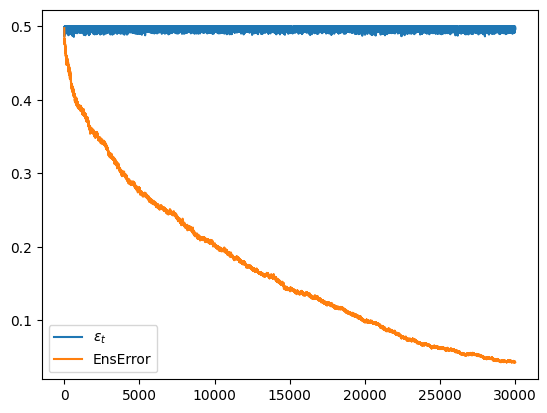

In [33]:
plt.plot(a.wl_errors, label=r"$\epsilon_t$")
plt.plot(a.ens_errors, label="EnsError")
plt.legend()
plt.show()

In [34]:
np.sum(y_train != y_train_)/len(y_train)

np.float64(0.042875)

In [35]:
np.sum(y_test != y_test_)/len(y_test)

np.float64(0.5005)